In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import ecco_v4_py as ecco

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Import ECCO dataset

In [2]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

### Useful quantities

In [3]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

### Define the section lines 

In [4]:
pt1,pt2 = ecco.get_section_endpoints('Barents Sea')
maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

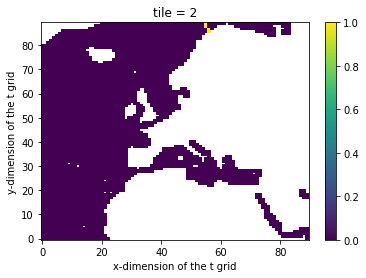

In [5]:
maskC[2].where(main.hFacC[0,2].values==1).plot()

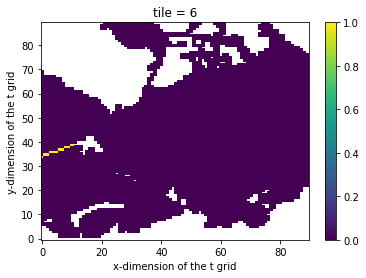

In [6]:
maskC[6].where(main.hFacC[0,6].values==1).plot()

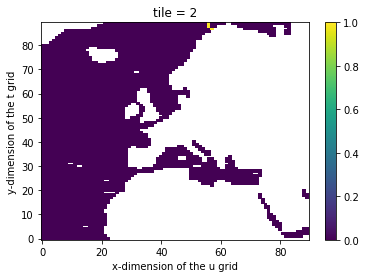

In [7]:
maskW[2].where(main.hFacW[0,2].values==1).plot()

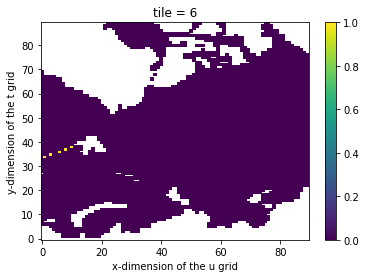

In [8]:
maskW[6].where(main.hFacW[0,6].values==1).plot()

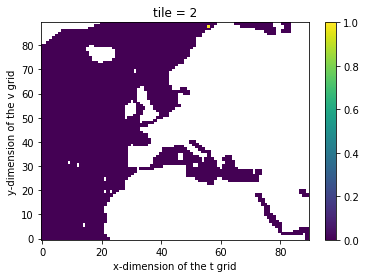

In [9]:
maskS[2].where(main.hFacS[0,2].values==1).plot()

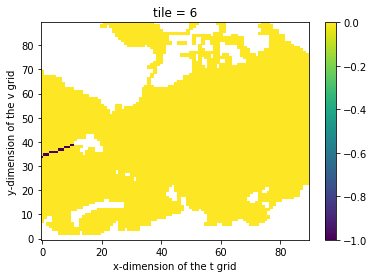

In [10]:
maskS[6].where(main.hFacS[0,6].values==1).plot()

### Grid area along section

**$X$**: ds.UVELMASS
`hFacW`, `maskW`
- Tile 2: zonal
- Tile 6: meridional
- Tile 10: meridional

**$Y$**: ds.VVELMASS
`hFacS`, `maskS`
- Tile 2: meridional
- Tile 6: zonal
- Tile 10: zonal

In [11]:
# Cell area along y at u location (m^2)
dyA = main.dyG*main.drF*main.hFacW

# Cell area along x at v location (m^2)
dxA = main.dxG*main.drF*main.hFacS

In [12]:
# Get area for Davis Strait
dyA_BSO = dyA*maskW
dxA_BSO_tile6 = dxA[6]*maskS[6]*-1
dxA_BSO_tile2 = dxA[2]*maskS[2]

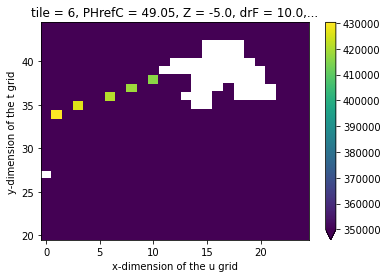

In [13]:
dyA_BSO[6,:,:,0].where(main.hFacW[0,6].values==1)[20:45,:25].plot(vmin=3.5e5)

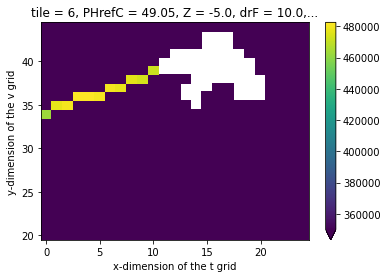

In [14]:
dxA_BSO_tile6[:,:,0].where(main.hFacS[0,6].values==1)[20:45,:25].plot(vmin=3.5e5)

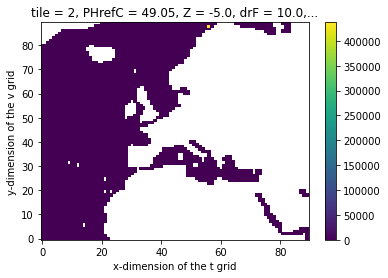

In [15]:
dxA_BSO_tile2[:,:,0].where(main.hFacS[0,2].values==1).plot()

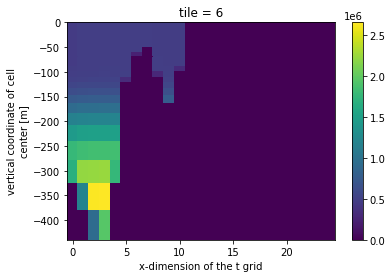

In [16]:
dxA_BSO_tile6.sum(dim=['j_g'])[:25,:22].T.swap_dims({'k':'Z'}).plot()

In [17]:
sec_area_x = dyA_BSO.sum(dim=['i_g','j','tile'])
sec_area_y = dxA_BSO_tile6.sum(dim=['i','j_g']) + dxA_BSO_tile2.sum(dim=['i','j_g'])

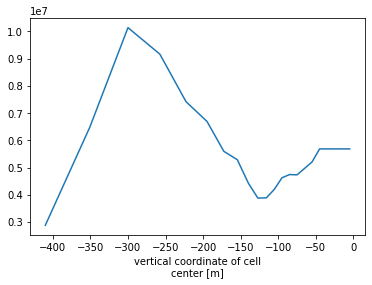

In [18]:
sec_area_y.swap_dims({'k':'Z'})[:22].plot()

In [19]:
# Section area (m^2)
sec_area = (sec_area_x + sec_area_y).sum('k').compute()

print('Area across the strait:',np.round(sec_area.values/1e6),'km^2')

Area across the strait: 195.0 km^2


### Volume flux

In [20]:
u_transport = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
v_transport = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

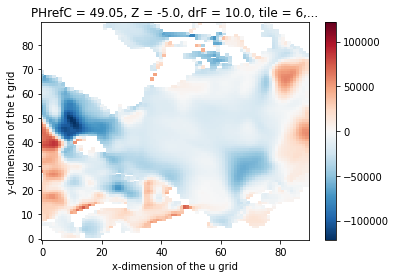

In [21]:
u_transport[:,0,6].mean('time').where(main.hFacW[0,6].values==1).plot()

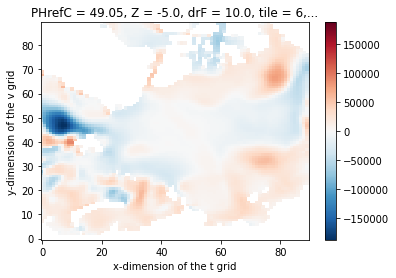

In [22]:
v_transport[:,0,6].mean('time').where(main.hFacS[0,6].values==1).plot()

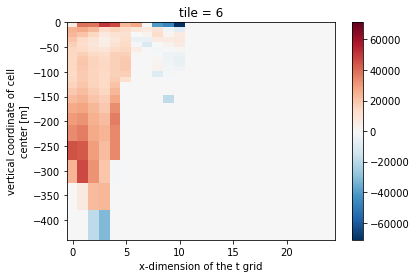

In [23]:
(v_transport * maskS)[:,:,6].sum(dim='j_g').mean('time')[:22,:25].swap_dims({'k':'Z'}).plot()#vmin=-1e5)

In [24]:
# Volume transports
sec_trsp_x = (u_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (v_transport * maskS).sum(dim=['i','j_g','tile'])

In [25]:
sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_trsp = sec_trsp.sel(time=slice('1993-01-01','2015-12-31'))

print('Vol. flux (1992-2015):', 
      np.round(sec_trsp.mean('time').values,1),'±',np.round(2*sec_trsp.std('time').values,1),'Sv')

Vol. flux (1992-2015): 3.3 ± 2.1 Sv


### Calculate freshwater fluxes

In [26]:
# Reference salinity
#Sref = 35.0
Sref = 34.8

In [27]:
grid = ecco.get_llc_grid(main)

In [28]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')

In [34]:
# Freshwater advective (Eulerian) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS+main.UVELSTAR)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS+main.VVELSTAR)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref

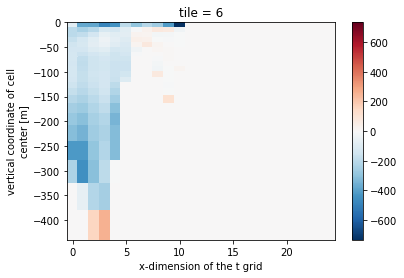

In [35]:
(ADVy_FW * maskS)[:,:,6].sum(dim='j_g').mean('time')[:22,:25].swap_dims({'k':'Z'}).plot()

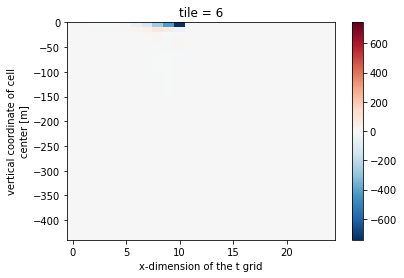

In [36]:
(ADVy_FW.where(SALT_at_v.values<=Sref)*maskS)[:,:,6].sum(dim='j_g').mean('time')[:22,:25]\
            .swap_dims({'k':'Z'}).plot()

In [37]:
# Full-depth integration
#sec_trsp_x = (ADVx_FW * maskW).sum(dim=['i_g','j','tile'])
#sec_trsp_y = (ADVy_FW * maskS).sum(dim=['i','j_g','tile'])

# Integration from isohaline
sec_trsp_x = (ADVx_FW.where(SALT_at_u.values<=Sref) * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (ADVy_FW.where(SALT_at_v.values<=Sref) * maskS).sum(dim=['i','j_g','tile'])

In [38]:
# Freshwater transport (Sv)
sec_FWtrsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_FWtrsp = sec_FWtrsp.sel(time=slice('1993-01-01','2015-12-31'))

#print('FW flux (Sref =',Sref, '/ full-depth integration','/ 1992-2015):', 
#      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')
print('FW flux (Sref =',Sref, '/ integration from isohaline','/ 1992-2015):', 
      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')

FW flux (Sref = 34.8 / integration from isohaline / 1992-2015): -1.5 ± 3.4 mSv


FW flux (Sref = 34.8 / integration from isohaline / 1992-2015): -0.2 ± 2.2 mSv


FW flux (Sref = 34.8 / full-depth integration / 1992-2015): -27.7 ± 21.2 mSv


FW flux (Sref = 35.0 / full-depth integration / 1992-2015): -8.5 ± 12.5 mSv
